In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold
from patsy import dmatrix
from sklearn.preprocessing import SplineTransformer
glogs_final = pd.read_csv('https://raw.githubusercontent.com/tmarchok1/DS440_project/refs/heads/Travis/glogs_final.csv')
glogs_final 
# Calculate and display average attendance for each team
team_avg_attendance = glogs_final.groupby('h_name')['attendance'].mean().sort_values(ascending=False)
print("Average Attendance for Each Team:")
print(team_avg_attendance)
# Create dummy model using only h_name variable
homedf = glogs_final.groupby('h_name')['attendance'].mean().sort_values().to_frame()
dummydf = pd.merge(glogs_final, homedf, on='h_name', how='left')
dummydf

# Evaluation metrics for dummy model
mse = mean_squared_error(dummydf['attendance_x'], dummydf['attendance_y'])
rmse = mse**(1/2)
r2 = r2_score(dummydf['attendance_x'], dummydf['attendance_y'])

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')













Average Attendance for Each Team:
h_name
NYY    45905.779381
LAD    44780.627572
STL    42027.073120
SF     39647.833162
LAA    39482.904321
CHC    37556.301653
PHI    36826.993789
BOS    36655.626543
NYM    35595.133751
DET    33803.340206
MIL    33320.729424
TEX    32485.770186
COL    31691.895769
MIN    30230.871531
ATL    29957.314700
SD     29055.022634
HOU    28855.463440
WSH    28451.419689
TOR    28391.088477
SEA    27153.922840
BAL    26784.755208
CHW    26762.625259
CIN    26634.605967
ARI    26489.550515
PIT    24644.318087
KC     22606.298755
CLE    21928.301042
OAK    21305.545549
MIA    19877.850312
TB     18610.508282
Name: attendance, dtype: float64
Mean Squared Error (MSE): 58894063.76
RMSE: 7674.25
R-squared Score (R²): 0.46


In [2]:
# Spline transform week into new encoded features
weeks = glogs_final[['week']]

# Fit sklearn spline transformer
spline = SplineTransformer(n_knots=5, degree=3, include_bias=False)
week_splined = spline.fit_transform(weeks)


# Create dataframe with transformed features
week_splined = pd.DataFrame(week_splined, columns=[f'week_spl{i}' for i in range(week_splined.shape[1])])
week_splined
# Calculate average attendance per team
avg_att = glogs_final.groupby('h_name')['attendance'].mean()

# Define thresholds for high, middle, and low attendance
attendance_category = avg_att.apply(
    lambda x: 'high' if x > 35000 else ('low' if x < 23000 else 'middle')
).to_dict()

# Map the attendance categories back to the original DataFrame
glogs_final['att_category'] = glogs_final['h_name'].map(attendance_category)

# Create the interaction variable between week and attendance category
glogs_final['week_group'] = 'week_' + glogs_final['week'].astype(str) + '_' + glogs_final['att_category']

# Drop the temporary attendance category column if no longer needed
glogs_final = glogs_final.drop(columns=['att_category'])

# Display the updated DataFrame
glogs_final
# Data preprocessing

# Merge with splined week features
# glogs_final = pd.concat([glogs_final, week_splined], axis=1)
# glogs_final

,date,year,week,day_of_week,v_name,h_name,day_night,park_id,temp,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,PayrollStd,attendance,week_group
0,2005-04-03,2005,1,Sun,BOS,NYY,1,Old Yankee Stadium,51.7,0.587,56937.0,101,1,1,3900000,19940274,2.830838,54818.0,week_1_high
1,2005-04-04,2005,1,Mon,OAK,BAL,0,Camden Yards,60.7,0.000,45971.0,78,0,0,746000,2859024,1.025050,48271.0,week_1_middle
2,2005-04-04,2005,1,Mon,CLE,CHW,0,US Cellular Field,56.2,0.000,40615.0,83,0,0,664000,9408576,1.034087,38141.0,week_1_middle
3,2005-04-04,2005,1,Mon,KC,DET,0,Comerica Park,59.0,0.000,41083.0,72,0,0,1000000,4400587,0.948452,44105.0,week_1_middle
4,2005-04-04,2005,1,Mon,MIN,SEA,0,Safeco Field,50.1,0.130,47943.0,63,0,0,927000,4145494,1.180556,46249.0,week_1_middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29030,2016-10-02,2016,24,Sun,MIL,COL,0,Coors Field,78.8,0.000,50144.0,68,0,0,552000,3052498,0.811287,27762.0,week_24_middle
29031,2016-10-02,2016,24,Sun,NYM,PHI,0,Citizens Bank Park,70.5,0.039,43651.0,63,0,0,1300000,6330422,1.098502,36935.0,week_24_high
29032,2016-10-02,2016,24,Sun,LAD,SF,0,AT&T Park,66.0,0.000,41915.0,84,0,0,1600000,4648486,1.374663,41445.0,week_24_high
29033,2016-10-02,2016,24,Sun,PIT,STL,0,Busch Stadium III,69.3,0.028,45494.0,100,1,1,1100000,2811927,0.993265,44615.0,week_24_high


In [3]:
# Drop columns
glogs_final = glogs_final.drop(columns=['date', "temp", "made_playoffs","won_division","capacity"])

# Binary encode 'day_of_week' and 'precip'
# glogs_final['day_of_week'] = glogs_final['day_of_week'].map({'Mon':0, 'Tue':0, 'Wed':0, 'Thu':0, 'Fri':1, 'Sat':1, 'Sun':1}).astype('int')
# glogs_final['precip'] = glogs_final['precip'].map(lambda x: 1 if x != 0 else 0)


# Apply OneHotEncoder to 'v_name', 'h_name', 'park_id' columns
encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), ['week_group', 'v_name', 'h_name', 'park_id', 'day_of_week'])],
    
    # Keep other columns
    remainder='passthrough'
)

df_encoded = encoder.fit_transform(glogs_final)

# Rename columns
feature_names = encoder.get_feature_names_out()
feature_names = [name.replace("remainder__", "") for name in feature_names]


In [4]:
df_encoded = pd.DataFrame(df_encoded, columns=feature_names)

df_encoded


feature_names
X = df_encoded.drop(columns=['attendance'])  # Exclude target variable
y = df_encoded['attendance']




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=29)

In [5]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=0.8,
    min_child_weight=4,
    
    random_state=42
)



In [6]:
# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on training set
y_train_pred = xgb_model.predict(X_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

In [7]:
# Training metrics
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mse_train ** 0.5
r2_train = r2_score(y_train, y_train_pred)

print(f'Training Mean Squared Error (MSE): {mse_train:.2f}')
print(f'Training RMSE: {rmse_train:.2f}')
print(f'Training R²: {r2_train:.2f}')

# Testing metrics
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mse_test ** 0.5
r2_test = r2_score(y_test, y_pred)

print(f'Test Mean Squared Error (MSE): {mse_test:.2f}')
print(f'Test RMSE: {rmse_test:.2f}')
print(f'Test R²: {r2_test:.2f}')


Training Mean Squared Error (MSE): 5903920.86
Training RMSE: 2429.80
Training R²: 0.95
Test Mean Squared Error (MSE): 16565471.92
Test RMSE: 4070.07
Test R²: 0.85


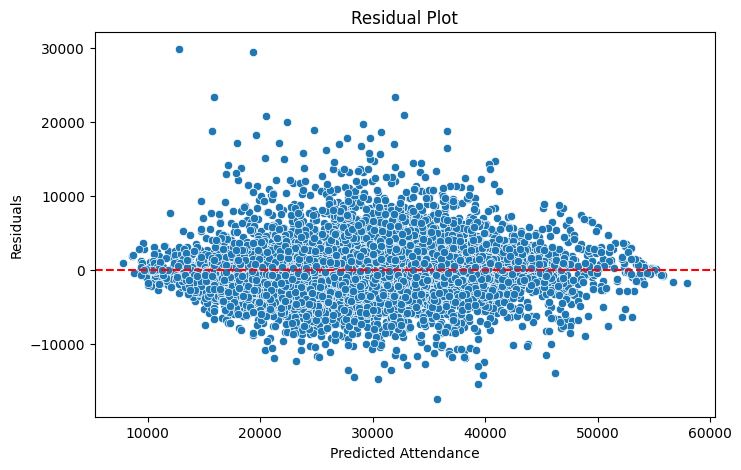

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Attendance')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
